In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [24]:
ax_params = {'lines.markeredgewidth':0,
             'font.sans-serif': 'Calibri',
             'axes.facecolor': '#ededed',
             'axes.edgecolor': '#3c3c3b',
             'axes.linewidth': 1.5,
             'axes.grid': True,
             'axes.axisbelow': True,
             'grid.color': '#f6f6f6',
             'grid.linewidth': 1.1,
             'legend.frameon': True,
             'legend.facecolor': '#ededed',
             'legend.edgecolor': 'white',}

In [3]:
tcga_meta = pd.read_csv('../data/processed/toil_tcga_sample_info_140722.csv')

In [59]:
class IsoPlot:
    
    colors = {'GTEX': '#9fcfad', 
              'TCGA normal unpaired': '#3fa170', 
              'TCGA normal paired': '#008f48', 
              'TCGA cancer paired': '#b33c36', 
              'TCGA cancer unpaired': '#cc9391',
              'DepMap lines': '#f39200'}
    
    sizes = {'GTEX': 2, 
             'TCGA normal unpaired': 3, 
             'TCGA normal paired': 3, 
             'TCGA cancer paired': 3, 
             'TCGA cancer unpaired': 3,
             'DepMap lines': 3}
    
    styles = {'GTEX': 'o', 
              'TCGA normal unpaired': 'o', 
              'TCGA normal paired': 'o', 
              'TCGA cancer paired': 'o', 
              'TCGA cancer unpaired': 'o',
              'DepMap lines': 'D'}
    
    def __init__(self):
        
        self.tcga_type = None
        self.tcga_type_data = None
        self.gtex_site = None
        self.gtex_site_data = None
        self.depmap_lines = None
        self.depmap_lines_data = None
        
    def __call__(self, ax, tcga_type, form1, form2, gtex_site=None, depmap_lines=None):
        
        if tcga_type != self.tcga_type:
            self.tcga_type = tcga_type
            self.tcga_type_data = pd.read_csv(f'../data/processed/toil/toil_tcga_{tcga_type.lower()}.csv', index_col=0)
        
        if gtex_site and (gtex_site != self.gtex_site):
            self.gtex_site = gtex_site
            self.gtex_site_data = pd.read_csv(f'../data/processed/toil/toil_gtex_{gtex_site}.csv', index_col=0)
        
        if depmap_lines and (depmap_lines != self.depmap_lines):
            self.depmap_lines = depmap_lines
            self.depmap_lines_data = pd.read_csv(f'../data/processed/depmap_22q1_expression_trs_processed_240422.csv', usecols=['enst_id'] + depmap_lines, index_col=0)
            self.depmap_lines_data.index.name = 'sample'
            
        coords = pd.DataFrame(columns=[form1, form2, 'hue'])
        
        if gtex_site:
            gtex_coords = self.gtex_site_data.loc[[form1, form2]].T
            gtex_coords['hue'] = 'GTEX'
            coords = pd.concat([coords, gtex_coords])
        
        tcga_meta_type = tcga_meta[tcga_meta['project'] == self.tcga_type.upper()]
        
        tcga_paired_cancer_ids = tcga_meta_type.loc[tcga_meta_type.duplicated('_sample_stem', keep=False) & (tcga_meta_type['sample_type'] == 'primary tumor'), 'sample']
        tcga_paired_normal_ids = tcga_meta_type.loc[tcga_meta_type.duplicated('_sample_stem', keep=False) & (tcga_meta_type['sample_type'] == 'normal tissue'), 'sample']
        tcga_unpaired_cancer_ids = tcga_meta_type.loc[(~tcga_meta_type.duplicated('_sample_stem', keep=False)) & (tcga_meta_type['sample_type'] == 'primary tumor'), 'sample']
        tcga_unpaired_normal_ids = tcga_meta_type.loc[(~tcga_meta_type.duplicated('_sample_stem', keep=False)) & (tcga_meta_type['sample_type'] == 'normal tissue'), 'sample']
        
        if not tcga_unpaired_normal_ids.empty:
            tcga_unpaired_normal_coords = self.tcga_type_data.loc[[form1, form2], tcga_unpaired_normal_ids].T
            tcga_unpaired_normal_coords['hue'] = 'TCGA cancer unpaired'
            coords = pd.concat([coords, tcga_unpaired_normal_coords])
        
        tcga_paired_normal_coords = self.tcga_type_data.loc[[form1, form2], tcga_paired_normal_ids].T
        tcga_paired_normal_coords['hue'] = 'TCGA normal paired'
        coords = pd.concat([coords, tcga_paired_normal_coords])
        
        tcga_unpaired_cancer_coords = self.tcga_type_data.loc[[form1, form2], tcga_unpaired_cancer_ids].T
        tcga_unpaired_cancer_coords['hue'] = 'TCGA cancer unpaired'
        coords = pd.concat([coords, tcga_unpaired_cancer_coords])
        
        tcga_paired_cancer_coords = self.tcga_type_data.loc[[form1, form2], tcga_paired_cancer_ids].T
        tcga_paired_cancer_coords['hue'] = 'TCGA cancer paired'
        coords = pd.concat([coords, tcga_paired_cancer_coords])
        
        
        if depmap_lines:
            depmap_coords = (2 ** self.depmap_lines_data.loc[[form1, form2]].T) - 1
            depmap_coords['hue'] = 'DepMap lines'
            coords = pd.concat([coords, depmap_coords])
        
        ax = sns.scatterplot(data=coords, x=form1, y=form2, hue='hue', palette=self.colors, legend='brief', ax=ax, s=50, linewidth=0)
        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
        
        ax.axis('square')
        
        if ax.get_xlim()[1] > ax.get_ylim()[1]:
            ax.set_ylim([-(ax.get_xlim()[1]/20), ax.get_xlim()[1]])
            ax.set_xlim([-(ax.get_xlim()[1]/20), ax.get_xlim()[1]])
        else:
            ax.set_xlim([-(ax.get_ylim()[1]/20), ax.get_ylim()[1]])
            ax.set_ylim([-(ax.get_ylim()[1]/20), ax.get_ylim()[1]])
        
        return ax

In [60]:
plot = IsoPlot()

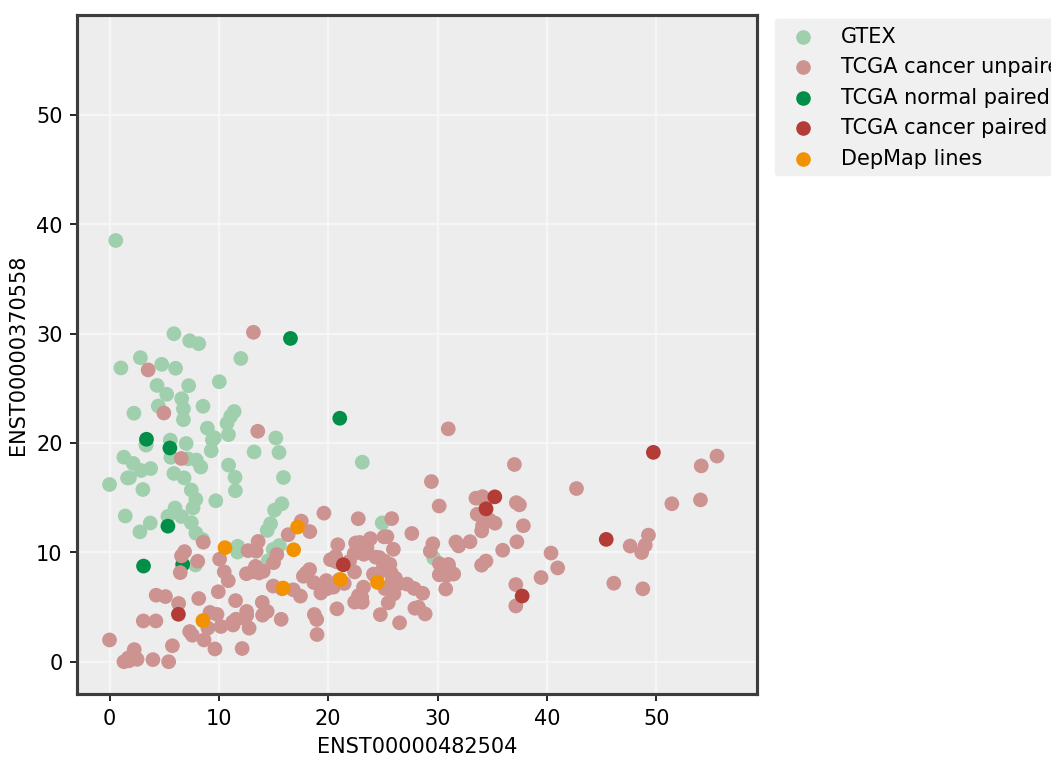

In [61]:
with mpl.rc_context(ax_params):
    fig, ax = plt.subplots(figsize=(9,6), dpi=150)
    a = plot(ax, 'UCEC', 'ENST00000482504', 'ENST00000370558', 'uterus', ['COLO684', 'EN', 'SNGM', 'MFE280', 'KLE', 'RL952', 'EFE184'])
    plt.savefig('test.png', bbox_inches='tight')

In [19]:
a.get_xlim()[1]

137.9955885

In [12]:
None == None

True

In [14]:
if not None:
    print('lol')

lol


In [19]:
dep = pd.read_csv('../data/processed/depmap_22q1_expression_trs_processed_240422.csv', nrows=2, usecols=['enst_id']+['143B', 'YKG1'], index_col=0)

In [20]:
dep

,143B,YKG1
enst_id,,
ENST00000263100,0.000000,0.000000
ENST00000595014,0.014355,0.687061
